Building a Local Rag

In [1]:
import torch


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.2.5 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "/Users/mac/6 semester Courses/Data Visualization/rag/.venv/lib/python3.11/site-packages/ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "/Users/mac/6 semester Courses/Data Visualization/rag/.venv/lib/python3.11/site-packages/traitlets/config/application.py", line 1075, in launch_instance
    app.start()
  File "/Users/mac/6 semester Courses/Data Visualization/rag/.venv/lib/pytho

In [3]:
# Download PDF file
import os
import requests

# Get PDF document
pdf_path = "benjamin-franklin.pdf"

# Download PDF if it doesn't already exist
if not os.path.exists(pdf_path):
  print("File doesn't exist, downloading...")

  # The URL of the PDF you want to download
  url = "https://github.com/isarmadsultan/books/blob/c5e2ba7ef169420498cbe96a0ea8708f89d4e9f0/benjamin-franklin.pdf"

  # The local filename to save the downloaded file
  filename = pdf_path

  # Send a GET request to the URL
  response = requests.get(url)

  # Check if the request was successful
  if response.status_code == 200:
      # Open a file in binary write mode and save the content to it
      with open(filename, "wb") as file:
          file.write(response.content)
      print(f"The file has been downloaded and saved as {filename}")
  else:
      print(f"Failed to download the file. Status code: {response.status_code}")
else:
  print(f"File {pdf_path} exists.")

File benjamin-franklin.pdf exists.


In [4]:
# Requires !pip install PyMuPDF, see: https://github.com/pymupdf/pymupdf
import fitz # (pymupdf, found this is better than pypdf for our use case, note: licence is AGPL-3.0, keep that in mind if you want to use any code commercially)
from tqdm.auto import tqdm # for progress bars, requires !pip install tqdm 

def text_formatter(text: str) -> str:
    """Performs minor formatting on text."""
    cleaned_text = text.replace("\n", " ").strip() # note: this might be different for each doc (best to experiment)

    # Other potential text formatting functions can go here
    return cleaned_text

# Open PDF and get lines/pages
# Note: this only focuses on text, rather than images/figures etc
def open_and_read_pdf(pdf_path: str) -> list[dict]:
    """
    Opens a PDF file, reads its text content page by page, and collects statistics.

    Parameters:
        pdf_path (str): The file path to the PDF document to be opened and read.

    Returns:
        list[dict]: A list of dictionaries, each containing the page number
        (adjusted), character count, word count, sentence count, token count, and the extracted text
        for each page.
    """
    doc = fitz.open(pdf_path)  # open a document
    pages_and_texts = []
    for page_number, page in tqdm(enumerate(doc)):  # iterate the document pages
        text = page.get_text()  # get plain text encoded as UTF-8
        text = text_formatter(text)
        pages_and_texts.append({"page_number": page_number,  # adjust page numbers since our PDF starts on page 42
                                "page_char_count": len(text),
                                "page_word_count": len(text.split(" ")),
                                "page_sentence_count_raw": len(text.split(". ")),
                                "page_token_count": len(text) / 4,  # 1 token = ~4 chars, see: https://help.openai.com/en/articles/4936856-what-are-tokens-and-how-to-count-them
                                "text": text})
    return pages_and_texts

pages_and_texts = open_and_read_pdf(pdf_path=pdf_path)
pages_and_texts[:2]

0it [00:00, ?it/s]

[{'page_number': 0,
  'page_char_count': 0,
  'page_word_count': 1,
  'page_sentence_count_raw': 1,
  'page_token_count': 0.0,
  'text': ''},
 {'page_number': 1,
  'page_char_count': 0,
  'page_word_count': 1,
  'page_sentence_count_raw': 1,
  'page_token_count': 0.0,
  'text': ''}]

In [5]:
import random

random.sample(pages_and_texts, k=3)

[{'page_number': 166,
  'page_char_count': 2194,
  'page_word_count': 358,
  'page_sentence_count_raw': 11,
  'page_token_count': 548.5,
  'text': 'He became an increasingly fervent opponent of the Proprietors, and eventually of the British, as they stubbornly asserted their right to control the taxes and government of the colony, a stance that reflected his anti-authoritarian and populist sentiments. He became a leader of the effort to get the colonies, heretofore truculently independent of one another, to join together and unite for common purposes, which reflected his penchant for forging associations, his nonparochial view of America, and his belief that people could accomplish more when they worked together than when they stood separately. The process began in 1753, when Franklin was appointed one of three commissioners from Pennsylvania to attend a summit conference with a congregation of Indian leaders at Carlisle, halfway between Philadelphia and the Ohio River. The goal was to

In [6]:
import pandas as pd

df = pd.DataFrame(pages_and_texts)
df.head()

,page_number,page_char_count,page_word_count,page_sentence_count_raw,page_token_count,text
0,0,0,1,1,0.00,
1,1,0,1,1,0.00,
2,2,103,19,1,25.75,Kissinger: A Biography The Wise Men: Six Frien...
3,3,0,1,1,0.00,
4,4,990,185,24,247.50,SIMON & SCHUSTER Rockefeller Center 1230 Avenu...


In [7]:
from spacy.lang.en import English # see https://spacy.io/usage for install instructions

nlp = English()

# Add a sentencizer pipeline, see https://spacy.io/api/sentencizer/ 
nlp.add_pipe("sentencizer")

# Create a document instance as an example
doc = nlp("This is a sentence. This another sentence.")
assert len(list(doc.sents)) == 2

# Access the sentences of the document
list(doc.sents)

[This is a sentence., This another sentence.]

In [8]:
for item in tqdm(pages_and_texts):
    item["sentences"] = list(nlp(item["text"]).sents)
    
    # Make sure all sentences are strings
    item["sentences"] = [str(sentence) for sentence in item["sentences"]]
    
    # Count the sentences 
    item["page_sentence_count_spacy"] = len(item["sentences"])

  0%|          | 0/675 [00:00<?, ?it/s]

In [9]:
# Inspect an example
random.sample(pages_and_texts, k=1)

[{'page_number': 366,
  'page_char_count': 2267,
  'page_word_count': 365,
  'page_sentence_count_raw': 10,
  'page_token_count': 566.75,
  'text': 'The philosophes of France were, like Franklin, eager to engage in the real world rather than lose themselves in abstruse metaphysics. Their secular version of the Bible was the Encyclopédie compiled by Diderot, which included articles by Turgot on economics, Montesquieu on politics, Rousseau on the arts, Condorcet on sciences, and Helvétius on man. Reigning as their king and god—or perhaps neither, as he was skeptical of both—was Voltaire, a man who contributed anonymously to the Encyclopédie but prominently to the intellectual life of France. Voltaire and Franklin were, at least in the mind of the French public, soul mates. Both were aging embodiments of the wit and reason of the Enlightenment, playful yet pointed parodists, debunkers of orthodoxy and pretense, disciples of deism, tribunes of tolerance, and apostles of revolution. So it w

In [10]:
df = pd.DataFrame(pages_and_texts)
df.describe().round(2)

,page_number,page_char_count,page_word_count,page_sentence_count_raw,page_token_count,page_sentence_count_spacy
count,675.0,675.00,675.00,675.00,675.00,675.00
mean,337.0,1917.85,319.69,14.47,479.46,15.44
std,195.0,653.11,113.89,10.72,163.28,7.96
min,0.0,0.00,1.00,1.00,0.00,0.00
25%,168.5,1936.50,319.50,10.00,484.12,13.00
50%,337.0,2203.00,367.00,13.00,550.75,16.00
75%,505.5,2312.00,388.00,16.00,578.00,19.00
max,674.0,2656.00,473.00,76.00,664.00,51.00


In [11]:
# Define split size to turn groups of sentences into chunks
num_sentence_chunk_size = 5 

# Create a function that recursively splits a list into desired sizes
def split_list(input_list: list, 
               slice_size: int) -> list[list[str]]:
    """
    Splits the input_list into sublists of size slice_size (or as close as possible).

    For example, a list of 17 sentences would be split into two lists of [[10], [7]]
    """
    return [input_list[i:i + slice_size] for i in range(0, len(input_list), slice_size)]

# Loop through pages and texts and split sentences into chunks
for item in tqdm(pages_and_texts):
    item["sentence_chunks"] = split_list(input_list=item["sentences"],
                                         slice_size=num_sentence_chunk_size)
    item["num_chunks"] = len(item["sentence_chunks"])

  0%|          | 0/675 [00:00<?, ?it/s]

In [58]:
# Sample an example from the group (note: many samples have only 1 chunk as they have <=10 sentences total)
random.sample(pages_and_texts, k=1)

[{'page_number': 471,
  'page_char_count': 2324,
  'page_word_count': 413,
  'page_sentence_count_raw': 9,
  'page_token_count': 581.0,
  'text': 'otherwise. It is therefore that, the older I grow, the more apt I am to doubt my own judgment and pay more respect to the judgment of others. Most men, indeed as well as most sects in religion, think themselves in possession of all truth, and that wherever others differ from them, it is so far error. Steele, a Protestant, in a dedication, tells the Pope that the only difference between our two churches in their opinions of the certainty of their doctrine is, the Romish Church is infallible, and the Church of England is never in the wrong. But, though many private persons think almost as highly of their own infallibility as of that of their sect, few express it so naturally as a certain French lady, who, in a little dispute with her sister said: “I don’t know how it happens, sister, but I meet with nobody but myself that is always in the righ

In [12]:
# Create a DataFrame to get stats
df = pd.DataFrame(pages_and_texts)
df.describe().round(2)

,page_number,page_char_count,page_word_count,page_sentence_count_raw,page_token_count,page_sentence_count_spacy,num_chunks
count,675.0,675.00,675.00,675.00,675.00,675.00,675.00
mean,337.0,1917.85,319.69,14.47,479.46,15.44,3.54
std,195.0,653.11,113.89,10.72,163.28,7.96,1.54
min,0.0,0.00,1.00,1.00,0.00,0.00,0.00
25%,168.5,1936.50,319.50,10.00,484.12,13.00,3.00
50%,337.0,2203.00,367.00,13.00,550.75,16.00,4.00
75%,505.5,2312.00,388.00,16.00,578.00,19.00,4.00
max,674.0,2656.00,473.00,76.00,664.00,51.00,11.00


In [13]:
import re

# Split each chunk into its own item
pages_and_chunks = []
for item in tqdm(pages_and_texts):
    for sentence_chunk in item["sentence_chunks"]:
        chunk_dict = {}
        chunk_dict["page_number"] = item["page_number"]
        
        # Join the sentences together into a paragraph-like structure, aka a chunk (so they are a single string)
        joined_sentence_chunk = "".join(sentence_chunk).replace("  ", " ").strip()
        joined_sentence_chunk = re.sub(r'\.([A-Z])', r'. \1', joined_sentence_chunk) # ".A" -> ". A" for any full-stop/capital letter combo 
        chunk_dict["sentence_chunk"] = joined_sentence_chunk

        # Get stats about the chunk
        chunk_dict["chunk_char_count"] = len(joined_sentence_chunk)
        chunk_dict["chunk_word_count"] = len([word for word in joined_sentence_chunk.split(" ")])
        chunk_dict["chunk_token_count"] = len(joined_sentence_chunk) / 4 # 1 token = ~4 characters
        
        pages_and_chunks.append(chunk_dict)

# How many chunks do we have?
len(pages_and_chunks)

  0%|          | 0/675 [00:00<?, ?it/s]

2390

In [14]:
random.sample(pages_and_chunks, k=1)

[{'page_number': 118,
  'sentence_chunk': 'Not only did he offer detailed theological rebuttals to each of the synod’s charges, but he accused its members of “malice and envy.”Hemphill’s accusers responded with their own pamphlet, which prompted Franklin to write another, even more vitriolic anonymous response that',
  'chunk_char_count': 273,
  'chunk_word_count': 41,
  'chunk_token_count': 68.25}]

In [15]:
# Get stats about our chunks
df = pd.DataFrame(pages_and_chunks)
df.describe().round(2)

,page_number,chunk_char_count,chunk_word_count,chunk_token_count
count,2390.00,2390.00,2390.00,2390.00
mean,333.62,540.18,89.54,135.05
std,184.35,265.20,44.75,66.30
min,2.00,3.00,1.00,0.75
25%,176.00,345.25,56.00,86.31
50%,334.50,551.50,91.00,137.88
75%,506.00,717.75,120.00,179.44
max,674.00,1570.00,268.00,392.50


In [16]:
# Show random chunks with under 30 tokens in length
min_token_length = 30
for row in df[df["chunk_token_count"] <= min_token_length].sample(5).iterrows():
    print(f'Chunk token count: {row[1]["chunk_token_count"]} | Text: {row[1]["sentence_chunk"]}')

Chunk token count: 1.0 | Text: That
Chunk token count: 30.0 | Text: But they would recall, years later, the fun they had talking for hours, exploring ideas, gently flirting. After two days
Chunk token count: 29.75 | Text: What then is the use of that word?”It was stricken out, and “hats” followed, the rather as there was one painted on the
Chunk token count: 4.25 | Text: Chapter Seventeen
Chunk token count: 2.0 | Text: His life


In [17]:
pages_and_chunks_over_min_token_len = df[df["chunk_token_count"] > min_token_length].to_dict(orient="records")
pages_and_chunks_over_min_token_len[:2]

[{'page_number': 4,
  'sentence_chunk': 'SIMON & SCHUSTER Rockefeller Center 1230 Avenue of the Americas New York, NY 10020 Copyright © 2003 by Walter Isaacson All rights reserved, including the right of reproduction in whole or in part in any form. SIMON AND SCHUSTER and colophon are registered trademarks of Simon & Schuster, Inc. Designed by Jaime Putorti Library of Congress Cataloging-in-Publication Data Isaacson, Walter. Benjamin Franklin and the invention of America : an American life / Walter Isaacson.  p. cm. Includes bibliographical references and index.',
  'chunk_char_count': 527,
  'chunk_word_count': 82,
  'chunk_token_count': 131.75},
 {'page_number': 4,
  'sentence_chunk': 'United States—Politics and government—1775–1783.4. United States—Politics and government—1783–1789.5. Scientists— United States—Biography.',
  'chunk_char_count': 138,
  'chunk_word_count': 11,
  'chunk_token_count': 34.5}]

In [18]:
# Requires !pip install sentence-transformers
from sentence_transformers import SentenceTransformer
embedding_model = SentenceTransformer(model_name_or_path="all-mpnet-base-v2", 
                                      device="cpu") # choose the device to load the model to (note: GPU will often be *much* faster than CPU)

# Create a list of sentences to turn into numbers
sentences = [
    "The Sentences Transformers library provides an easy and open-source way to create embeddings.",
    "Sentences can be embedded one by one or as a list of strings.",
    "Embeddings are one of the most powerful concepts in machine learning!",
    "Learn to use embeddings well and you'll be well on your way to being an AI engineer."
]

# Sentences are encoded/embedded by calling model.encode()
embeddings = embedding_model.encode(sentences)
embeddings_dict = dict(zip(sentences, embeddings))

# See the embeddings
for sentence, embedding in embeddings_dict.items():
    print("Sentence:", sentence)
    print("Embedding:", embedding)
    print("")

/Users/mac/6 semester Courses/Data Visualization/rag/.venv/lib/python3.11/site-packages/huggingface_hub/file_download.py:896: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/Users/mac/6 semester Courses/Data Visualization/rag/.venv/lib/python3.11/site-packages/huggingface_hub/file_download.py:896: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Sentence: The Sentences Transformers library provides an easy and open-source way to create embeddings.
Embedding: [-2.07982659e-02  3.03164814e-02 -2.01217812e-02  6.86484948e-02
 -2.55256258e-02 -8.47686827e-03 -2.07231977e-04 -6.32377416e-02
  2.81606596e-02 -3.33353728e-02  3.02633960e-02  5.30721396e-02
 -5.03526554e-02  2.62288544e-02  3.33313718e-02 -4.51577306e-02
  3.63045074e-02 -1.37121335e-03 -1.20171625e-02  1.14947166e-02
  5.04510924e-02  4.70856801e-02  2.11914051e-02  5.14606386e-02
 -2.03746390e-02 -3.58889215e-02 -6.67755026e-04 -2.94393897e-02
  4.95859198e-02 -1.05639463e-02 -1.52014066e-02 -1.31760491e-03
  4.48197499e-02  1.56023446e-02  8.60379259e-07 -1.21392065e-03
 -2.37978753e-02 -9.09372466e-04  7.34484568e-03 -2.53931386e-03
  5.23370616e-02 -4.68043797e-02  1.66214872e-02  4.71579544e-02
 -4.15599197e-02  9.01963329e-04  3.60278040e-02  3.42213996e-02
  9.68226939e-02  5.94829135e-02 -1.64984576e-02 -3.51249389e-02
  5.92516316e-03 -7.07909290e-04 -2.4103

In [19]:
single_sentence = "Yo! How cool are embeddings?"
single_embedding = embedding_model.encode(single_sentence)
print(f"Sentence: {single_sentence}")
print(f"Embedding:\n{single_embedding}")
print(f"Embedding size: {single_embedding.shape}")

Sentence: Yo! How cool are embeddings?
Embedding:
[-1.97448079e-02 -4.51076636e-03 -4.98487381e-03  6.55445009e-02
 -9.87673923e-03  2.72835921e-02  3.66426446e-02 -3.30219488e-03
  8.50078370e-03  8.24952591e-03 -2.28497572e-02  4.02430035e-02
 -5.75200468e-02  6.33692071e-02  4.43207324e-02 -4.49506305e-02
  1.25284633e-02 -2.52011809e-02 -3.55292968e-02  1.29559245e-02
  8.67021270e-03 -1.92917809e-02  3.55636817e-03  1.89505816e-02
 -1.47128142e-02 -9.39845107e-03  7.64174573e-03  9.62185301e-03
 -5.98922325e-03 -3.90168838e-02 -5.47824688e-02 -5.67454379e-03
  1.11644613e-02  4.08067293e-02  1.76319122e-06  9.15304385e-03
 -8.77259858e-03  2.39382703e-02 -2.32784487e-02  8.05000216e-02
  3.19177061e-02  5.12601668e-03 -1.47708217e-02 -1.62524972e-02
 -6.03212900e-02 -4.35689948e-02  4.51211371e-02 -1.79053862e-02
  2.63366625e-02 -3.47866677e-02 -8.89173150e-03 -5.47675341e-02
 -1.24373063e-02 -2.38606650e-02  8.33497196e-02  5.71241640e-02
  1.13328611e-02 -1.49594918e-02  9.2037

In [20]:
%%time

# Uncomment to see how long it takes to create embeddings on CPU
# # Make sure the model is on the CPU
# embedding_model.to("cpu")

# # Embed each chunk one by one
# for item in tqdm(pages_and_chunks_over_min_token_len):
#     item["embedding"] = embedding_model.encode(item["sentence_chunk"])

CPU times: user 8 μs, sys: 6 μs, total: 14 μs
Wall time: 76.1 μs


In [21]:
%%time

# Send the model to the GPU
embedding_model.to("cpu") # requires a GPU installed, for reference on my local machine, I'm using a NVIDIA RTX 4090

# Create embeddings one by one on the GPU
for item in tqdm(pages_and_chunks_over_min_token_len):
    item["embedding"] = embedding_model.encode(item["sentence_chunk"])

  0%|          | 0/2252 [00:00<?, ?it/s]

CPU times: user 14min 16s, sys: 17.2 s, total: 14min 33s
Wall time: 8min 6s


In [22]:
text_chunks = [item["sentence_chunk"] for item in pages_and_chunks_over_min_token_len]

In [23]:
%%time

# Embed all texts in batches
text_chunk_embeddings = embedding_model.encode(text_chunks,
                                               batch_size=32, # you can use different batch sizes here for speed/performance, I found 32 works well for this use case
                                               convert_to_tensor=True) # optional to return embeddings as tensor instead of array

text_chunk_embeddings

CPU times: user 18min 35s, sys: 52.4 s, total: 19min 28s
Wall time: 10min 47s


tensor([[-0.0050,  0.1048, -0.0191,  ..., -0.0121, -0.0094, -0.0209],
        [ 0.0172,  0.1075,  0.0120,  ...,  0.0449, -0.0079, -0.0062],
        [-0.0102, -0.0944, -0.0016,  ..., -0.0059, -0.0580, -0.0241],
        ...,
        [-0.0006,  0.0576,  0.0282,  ...,  0.0352, -0.0098,  0.0134],
        [ 0.0376,  0.0549,  0.0275,  ...,  0.0028,  0.0526, -0.0313],
        [-0.0265,  0.1298,  0.0039,  ...,  0.0436,  0.0015,  0.0050]])

In [24]:
text_chunks_and_embeddings_df = pd.DataFrame(pages_and_chunks_over_min_token_len)
embeddings_df_save_path = "text_chunks_and_embeddings_df.csv"
text_chunks_and_embeddings_df.to_csv(embeddings_df_save_path, index=False)

In [25]:
text_chunks_and_embedding_df_load = pd.read_csv(embeddings_df_save_path)
text_chunks_and_embedding_df_load.head()

,page_number,sentence_chunk,chunk_char_count,chunk_word_count,chunk_token_count,embedding
0,4,SIMON & SCHUSTER Rockefeller Center 1230 Avenu...,527,82,131.75,[-4.97977715e-03 1.04847737e-01 -1.91396102e-...
1,4,United States—Politics and government—1775–178...,138,11,34.50,[ 1.72432009e-02 1.07471235e-01 1.19900722e-...
2,4,E302.6F8I83 2003 973.3’092—dc21 [B] ...,123,36,30.75,[-1.02482475e-02 -9.43745151e-02 -1.59404543e-...
3,7,CONTENTS CHAPTER ONE Benjamin Franklin and the...,497,60,124.25,[-5.20289876e-02 1.14097692e-01 -7.33247120e-...
4,8,"Agent Provocateur: London, 1765–1770 CHAPTER E...",465,52,116.25,[-1.10459402e-02 1.07712977e-01 1.53584629e-...


In [26]:
import random

import torch
import numpy as np 
import pandas as pd

device = "cuda" if torch.cuda.is_available() else "cpu"

# Import texts and embedding df
text_chunks_and_embedding_df = pd.read_csv("text_chunks_and_embeddings_df.csv")

# Convert embedding column back to np.array (it got converted to string when it got saved to CSV)
text_chunks_and_embedding_df["embedding"] = text_chunks_and_embedding_df["embedding"].apply(lambda x: np.fromstring(x.strip("[]"), sep=" "))

# Convert texts and embedding df to list of dicts
pages_and_chunks = text_chunks_and_embedding_df.to_dict(orient="records")

# Convert embeddings to torch tensor and send to device (note: NumPy arrays are float64, torch tensors are float32 by default)
embeddings = torch.tensor(np.array(text_chunks_and_embedding_df["embedding"].tolist()), dtype=torch.float32).to(device)
embeddings.shape

torch.Size([2252, 768])

In [27]:
text_chunks_and_embedding_df.head()

,page_number,sentence_chunk,chunk_char_count,chunk_word_count,chunk_token_count,embedding
0,4,SIMON & SCHUSTER Rockefeller Center 1230 Avenu...,527,82,131.75,"[-0.00497977715, 0.104847737, -0.0191396102, 0..."
1,4,United States—Politics and government—1775–178...,138,11,34.50,"[0.0172432009, 0.107471235, 0.0119900722, -0.0..."
2,4,E302.6F8I83 2003 973.3’092—dc21 [B] ...,123,36,30.75,"[-0.0102482475, -0.0943745151, -0.00159404543,..."
3,7,CONTENTS CHAPTER ONE Benjamin Franklin and the...,497,60,124.25,"[-0.0520289876, 0.114097692, -0.0073324712, -0..."
4,8,"Agent Provocateur: London, 1765–1770 CHAPTER E...",465,52,116.25,"[-0.0110459402, 0.107712977, 0.0153584629, 0.0..."


In [28]:
embeddings[0]

tensor([-4.9798e-03,  1.0485e-01, -1.9140e-02,  3.2617e-04,  8.5299e-03,
         1.8246e-02,  4.5717e-02, -1.1488e-02, -6.7134e-03, -3.2204e-02,
         2.7042e-02,  6.3560e-02,  5.0895e-03,  2.4388e-02, -2.6807e-02,
         3.2879e-02,  1.2155e-02,  5.9150e-02,  2.7591e-02,  3.2784e-02,
        -2.8068e-02,  1.1390e-02, -1.0708e-02,  5.8927e-04,  2.4626e-02,
        -1.3012e-02,  7.2609e-02, -6.1790e-02,  4.8981e-03, -7.2649e-02,
         3.3334e-02,  5.4700e-02, -1.9337e-02, -3.2512e-02,  2.3005e-06,
        -1.3745e-02,  8.4592e-02,  6.5681e-03, -3.6667e-02,  1.7701e-02,
         9.0508e-02,  4.7176e-02, -3.0195e-03,  3.0623e-02, -5.5853e-02,
        -3.5407e-02, -7.9390e-02,  2.3522e-02, -1.0509e-01, -5.9750e-02,
        -3.7181e-04, -3.8120e-02,  4.2140e-02, -4.5104e-02, -3.4781e-02,
         2.7987e-02, -8.1050e-03,  9.8101e-03,  4.3531e-03,  6.6548e-03,
         3.5490e-03,  1.5661e-02, -2.5219e-03,  1.6234e-02,  3.8400e-02,
        -5.4806e-03, -5.2152e-02,  6.3796e-04, -1.2

In [29]:
from sentence_transformers import util, SentenceTransformer

embedding_model = SentenceTransformer(model_name_or_path="all-mpnet-base-v2", 
                                      device=device) # choose the device to load the model to

/Users/mac/6 semester Courses/Data Visualization/rag/.venv/lib/python3.11/site-packages/huggingface_hub/file_download.py:896: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [30]:
# 1. Define the query
# Note: This could be anything. But since we're working with a nutrition textbook, we'll stick with nutrition-based queries.
query = "inventions by franklin"
print(f"Query: {query}")

# 2. Embed the query to the same numerical space as the text examples 
# Note: It's important to embed your query with the same model you embedded your examples with.
query_embedding = embedding_model.encode(query, convert_to_tensor=True)

# 3. Get similarity scores with the dot product (we'll time this for fun)
from time import perf_counter as timer

start_time = timer()
dot_scores = util.dot_score(a=query_embedding, b=embeddings)[0]
end_time = timer()

print(f"Time take to get scores on {len(embeddings)} embeddings: {end_time-start_time:.5f} seconds.")

# 4. Get the top-k results (we'll keep this to 5)
top_results_dot_product = torch.topk(dot_scores, k=5)
top_results_dot_product

Query: inventions by franklin
Time take to get scores on 2252 embeddings: 0.00352 seconds.


torch.return_types.topk(
values=tensor([0.7641, 0.7275, 0.7224, 0.7182, 0.7159]),
indices=tensor([1541,  437,  436,  473,  443]))

In [31]:
larger_embeddings = torch.randn(100*embeddings.shape[0], 768).to(device)
print(f"Embeddings shape: {larger_embeddings.shape}")

# Perform dot product across 168,000 embeddings
start_time = timer()
dot_scores = util.dot_score(a=query_embedding, b=larger_embeddings)[0]
end_time = timer()

print(f"Time take to get scores on {len(larger_embeddings)} embeddings: {end_time-start_time:.5f} seconds.")

Embeddings shape: torch.Size([225200, 768])
Time take to get scores on 225200 embeddings: 0.05473 seconds.


In [32]:
# Define helper function to print wrapped text 
import textwrap

def print_wrapped(text, wrap_length=80):
    wrapped_text = textwrap.fill(text, wrap_length)
    print(wrapped_text)

In [33]:
print(f"Query: '{query}'\n")
print("Results:")
# Loop through zipped together scores and indicies from torch.topk
for score, idx in zip(top_results_dot_product[0], top_results_dot_product[1]):
    print(f"Score: {score:.4f}")
    # Print relevant sentence chunk (since the scores are in descending order, the most relevant chunk will be first)
    print("Text:")
    print_wrapped(pages_and_chunks[idx]["sentence_chunk"])
    # Print the page number too so we can reference the textbook further (and check the results)
    print(f"Page number: {pages_and_chunks[idx]['page_number']}")
    print("\n")

Query: 'inventions by franklin'

Results:
Score: 0.7641
Text:
He was satisfied to discover, during the renovation of his main house, that a
bolt had melted the tip of its old lightning rod while he was in France, but the
house had remained unscathed, “so that at length the invention has been of some
use to the inventor.”9 Besides all his books, his new library boasted a variety
of scientific paraphernalia, including his electricity equipment and a glass
machine that exhibited the flow of blood through the body. For his reading
comfort, Franklin built a great armchair set on rockers with an overhead fan
that was powered by a foot pedal. Among his musical instruments were an
armonica, a harpsichord, a “glassichord” similar to his armonica, a viola, and
bells. From James Watt, the famed Birmingham steam engine maker, he imported,
and made some improvements on, the first rudimentary copying machine.
Page number: 454


Score: 0.7275
Text:
But during his life he was celebrated as the most fa

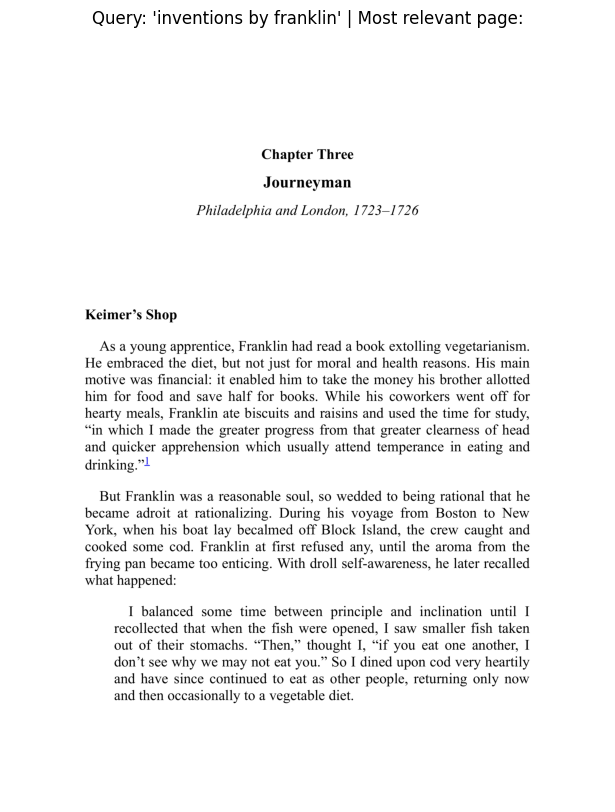

In [34]:
import fitz

# Open PDF and load target page
pdf_path = "/Users/mac/6 semester Courses/Data Visualization/rag/simple-local-rag/benjamin-franklin.pdf" # requires PDF to be downloaded
doc = fitz.open(pdf_path)
page = doc.load_page(5 + 41) # number of page (our doc starts page numbers on page 41)

# Get the image of the page
img = page.get_pixmap(dpi=300)

# Optional: save the image
#img.save("output_filename.png")
doc.close()

# Convert the Pixmap to a numpy array
img_array = np.frombuffer(img.samples_mv, 
                          dtype=np.uint8).reshape((img.h, img.w, img.n))

# Display the image using Matplotlib
import matplotlib.pyplot as plt
plt.figure(figsize=(13, 10))
plt.imshow(img_array)
plt.title(f"Query: '{query}' | Most relevant page:")
plt.axis('off') # Turn off axis
plt.show()

In [35]:
import torch

def dot_product(vector1, vector2):
    return torch.dot(vector1, vector2)

def cosine_similarity(vector1, vector2):
    dot_product = torch.dot(vector1, vector2)

    # Get Euclidean/L2 norm of each vector (removes the magnitude, keeps direction)
    norm_vector1 = torch.sqrt(torch.sum(vector1**2))
    norm_vector2 = torch.sqrt(torch.sum(vector2**2))

    return dot_product / (norm_vector1 * norm_vector2)

# Example tensors
vector1 = torch.tensor([1, 2, 3], dtype=torch.float32)
vector2 = torch.tensor([1, 2, 3], dtype=torch.float32)
vector3 = torch.tensor([4, 5, 6], dtype=torch.float32)
vector4 = torch.tensor([-1, -2, -3], dtype=torch.float32)

# Calculate dot product
print("Dot product between vector1 and vector2:", dot_product(vector1, vector2))
print("Dot product between vector1 and vector3:", dot_product(vector1, vector3))
print("Dot product between vector1 and vector4:", dot_product(vector1, vector4))

# Calculate cosine similarity
print("Cosine similarity between vector1 and vector2:", cosine_similarity(vector1, vector2))
print("Cosine similarity between vector1 and vector3:", cosine_similarity(vector1, vector3))
print("Cosine similarity between vector1 and vector4:", cosine_similarity(vector1, vector4))

Dot product between vector1 and vector2: tensor(14.)
Dot product between vector1 and vector3: tensor(32.)
Dot product between vector1 and vector4: tensor(-14.)
Cosine similarity between vector1 and vector2: tensor(1.0000)
Cosine similarity between vector1 and vector3: tensor(0.9746)
Cosine similarity between vector1 and vector4: tensor(-1.0000)


In [36]:
def retrieve_relevant_resources(query: str,
                                embeddings: torch.tensor,
                                model: SentenceTransformer=embedding_model,
                                n_resources_to_return: int=5,
                                print_time: bool=True):
    """
    Embeds a query with model and returns top k scores and indices from embeddings.
    """

    # Embed the query
    query_embedding = model.encode(query, 
                                   convert_to_tensor=True) 

    # Get dot product scores on embeddings
    start_time = timer()
    dot_scores = util.dot_score(query_embedding, embeddings)[0]
    end_time = timer()

    if print_time:
        print(f"[INFO] Time taken to get scores on {len(embeddings)} embeddings: {end_time-start_time:.5f} seconds.")

    scores, indices = torch.topk(input=dot_scores, 
                                 k=n_resources_to_return)

    return scores, indices

def print_top_results_and_scores(query: str,
                                 embeddings: torch.tensor,
                                 pages_and_chunks: list[dict]=pages_and_chunks,
                                 n_resources_to_return: int=5):
    """
    Takes a query, retrieves most relevant resources and prints them out in descending order.

    Note: Requires pages_and_chunks to be formatted in a specific way (see above for reference).
    """
    
    scores, indices = retrieve_relevant_resources(query=query,
                                                  embeddings=embeddings,
                                                  n_resources_to_return=n_resources_to_return)
    
    print(f"Query: {query}\n")
    print("Results:")
    # Loop through zipped together scores and indicies
    for score, index in zip(scores, indices):
        print(f"Score: {score:.4f}")
        # Print relevant sentence chunk (since the scores are in descending order, the most relevant chunk will be first)
        print_wrapped(pages_and_chunks[index]["sentence_chunk"])
        # Print the page number too so we can reference the textbook further and check the results
        print(f"Page number: {pages_and_chunks[index]['page_number']}")
        print("\n")

In [37]:
query = "could you summarize the whole human nutrition?"

# Get just the scores and indices of top related results
scores, indices = retrieve_relevant_resources(query=query,
                                              embeddings=embeddings)
scores, indices

[INFO] Time taken to get scores on 2252 embeddings: 0.01075 seconds.


(tensor([0.4142, 0.3372, 0.3121, 0.3016, 0.3004]),
 tensor([1289,  122,  121,  131, 1290]))

In [38]:
# Print out the texts of the top scores
print_top_results_and_scores(query=query,
                             embeddings=embeddings)

[INFO] Time taken to get scores on 2252 embeddings: 0.00054 seconds.
Query: could you summarize the whole human nutrition?

Results:
Score: 0.4142
Why, instead of gaining an appetite for breakfast by salutary exercise, you
amuse yourself with books, pamphlets, or newspapers, which commonly are not
worth the reading. Yet you eat an inordinate breakfast,
Page number: 381


Score: 0.3372
During his voyage from Boston to New York, when his boat lay becalmed off Block
Island, the crew caught and cooked some cod. Franklin at first refused any,
until the aroma from the frying pan became too enticing. With droll self-
awareness, he later recalled what happened: I balanced some time between
principle and inclination until I recollected that when the fish were opened, I
saw smaller fish taken out of their stomachs. “Then,” thought I, “if you eat one
another, I don’t see why we may not eat you.”So I dined upon cod very heartily
and have since continued to eat as other people, returning only now a

In [55]:
import torch
import numpy as np
import pandas as pd
from sentence_transformers import SentenceTransformer, util
from time import perf_counter as timer
import textwrap
import requests
import json
import os

# Check if Ollama is running locally
def check_ollama_status():
    try:
        response = requests.get("http://localhost:11434/api/tags")
        if response.status_code == 200:
            models = response.json()
            print(f"Ollama is running. Available models: {[model['name'] for model in models['models']]}")
            return True
        else:
            print(f"Ollama API responded with status code {response.status_code}")
            return False
    except requests.exceptions.ConnectionError:
        print("Cannot connect to Ollama API. Make sure Ollama is running.")
        print("You can start it with 'ollama serve' command.")
        return False

# Function to pull a model from Ollama if not already available
def pull_model(model_name="llama3"):
    try:
        # Check if model exists
        response = requests.get("http://localhost:11434/api/tags")
        models = response.json()
        model_exists = any(model['name'] == model_name for model in models.get('models', []))
        
        if not model_exists:
            print(f"Pulling model {model_name}...")
            response = requests.post(
                "http://localhost:11434/api/pull",
                json={"name": model_name}
            )
            if response.status_code == 200:
                print(f"Successfully pulled {model_name}")
            else:
                print(f"Failed to pull {model_name}: {response.text}")
        else:
            print(f"Model {model_name} already exists")
        return True
    except Exception as e:
        print(f"Error pulling model: {e}")
        return False

# Function to query Ollama
def query_ollama(prompt, model_name="llama3", system_prompt=None, temperature=0.7, stream=False):
    url = "http://localhost:11434/api/generate"
    
    payload = {
        "model": model_name,
        "prompt": prompt,
        "temperature": temperature,
        "stream": stream
    }
    
    if system_prompt:
        payload["system"] = system_prompt
    
    try:
        if stream:
            # Stream response
            response = requests.post(url, json=payload, stream=True)
            response_text = ""
            for line in response.iter_lines():
                if line:
                    chunk = json.loads(line)
                    if 'response' in chunk:
                        response_text += chunk['response']
                        print(chunk['response'], end='', flush=True)
                    if chunk.get('done', False):
                        print()  # New line at the end
                        break
            return response_text
        else:
            # Single response
            response = requests.post(url, json=payload)
            if response.status_code == 200:
                return response.json().get('response', '')
            else:
                print(f"Error: {response.status_code}")
                print(response.text)
                return ""
    except Exception as e:
        print(f"Error querying Ollama: {e}")
        return ""

# Load the embedding model and data
def load_embedding_data(embedding_file="text_chunks_and_embeddings_df.csv"):
    # Load the dataframe and convert embeddings back to arrays
    df = pd.read_csv(embedding_file)
    df["embedding"] = df["embedding"].apply(lambda x: np.fromstring(x.strip("[]"), sep=" "))
    
    # Convert to list of dicts and tensor
    pages_and_chunks = df.to_dict(orient="records")
    device = "cuda" if torch.cuda.is_available() else "cpu"
    embeddings = torch.tensor(np.array(df["embedding"].tolist()), dtype=torch.float32).to(device)
    
    # Load the model
    embedding_model = SentenceTransformer(model_name_or_path="all-mpnet-base-v2", device=device)
    
    return embedding_model, embeddings, pages_and_chunks

# Retrieve relevant resources based on query
def retrieve_relevant_resources(query, embeddings, model, n_resources=5, print_time=True):
    # Embed the query
    query_embedding = model.encode(query, convert_to_tensor=True)
    
    # Get dot product scores
    start_time = timer()
    dot_scores = util.dot_score(query_embedding, embeddings)[0]
    end_time = timer()
    
    if print_time:
        print(f"[INFO] Time taken to get scores on {len(embeddings)} embeddings: {end_time-start_time:.5f} seconds.")
    
    scores, indices = torch.topk(input=dot_scores, k=n_resources)
    
    return scores, indices

# Format the retrieved chunks for the LLM context
def format_context_from_chunks(pages_and_chunks, indices):
    context = ""
    for idx in indices:
        chunk = pages_and_chunks[idx]["sentence_chunk"]
        page_num = pages_and_chunks[idx]["page_number"]
        context += f"[Page {page_num}]: {chunk}\n\n"
    return context

# Print nicely wrapped text
def print_wrapped(text, wrap_length=80):
    wrapped_text = textwrap.fill(text, wrap_length)
    print(wrapped_text)

# Complete RAG pipeline
def rag_query(user_query, model_name="llama3", num_chunks=5):
    # Load embedding model and data
    embedding_model, embeddings, pages_and_chunks = load_embedding_data()
    
    # Retrieve relevant chunks
    scores, indices = retrieve_relevant_resources(
        query=user_query,
        embeddings=embeddings,
        model=embedding_model,
        n_resources=num_chunks,
        print_time=True
    )
    
    # Format context from the retrieved chunks
    context = format_context_from_chunks(pages_and_chunks, indices)
    
    # Create a prompt with the retrieved context
    system_prompt = """You are a helpful AI assistant that answers questions based on the provided context.
Use only the information from the context to answer. If the context doesn't contain relevant information,
say "I don't have enough information to answer this question." Do not make up information."""
    
    rag_prompt = f"""I'll answer your question based on the following context:

{context}

Your question: {user_query}

My answer:"""
    
    # Query Ollama with the context-enriched prompt
    response = query_ollama(
        prompt=rag_prompt,
        model_name=model_name,
        system_prompt=system_prompt,
        temperature=0.5,
        stream=True
    )
    
    return response

# Example usage
if __name__ == "__main__":
    # Check if Ollama is running
    if check_ollama_status():
        # Pull the model if needed
        model_name = "llama3"  # You can change this to any model available in Ollama
        if pull_model(model_name):
            # Execute a RAG query
            query = "What inventions did Benjamin Franklin create?"
            print(f"\nQuery: {query}")
            print("\nGenerating response...\n")
            response = rag_query(query, model_name=model_name)
            print("\nDone!")

Ollama is running. Available models: ['mistral:latest', 'llama2:latest']
Pulling model llama3...
Successfully pulled llama3

Query: What inventions did Benjamin Franklin create?

Generating response...



/Users/mac/6 semester Courses/Data Visualization/rag/.venv/lib/python3.11/site-packages/huggingface_hub/file_download.py:896: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


[INFO] Time taken to get scores on 2252 embeddings: 0.00066 seconds.
According to the context, Benjamin Franklin created the following inventions:

1. Lightning rod
2. Electricity equipment (not specified what type)
3. Glass machine that exhibited the flow of blood through the body
4. Foot-pedal powered fan for his armchair
5. Rudimentary copying machine (with improvements from James Watt)

Please note that these are the only specific inventions mentioned in the provided context.

Done!


In [56]:
if __name__ == "__main__":
    # Check if Ollama is running
    if check_ollama_status():
        # Pull the model if needed
        model_name = "llama3"  # You can change this to any model available in Ollama
        if pull_model(model_name):
            # Execute a RAG query
            query = "What is the kite story in the journey of franklin?"
            print(f"\nQuery: {query}")
            print("\nGenerating response...\n")
            response = rag_query(query, model_name=model_name)
            print("\nDone!")

Ollama is running. Available models: ['llama3:latest', 'mistral:latest', 'llama2:latest']
Pulling model llama3...
Successfully pulled llama3

Query: What is the kite story in the journey of franklin?

Generating response...



/Users/mac/6 semester Courses/Data Visualization/rag/.venv/lib/python3.11/site-packages/huggingface_hub/file_download.py:896: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


[INFO] Time taken to get scores on 2252 embeddings: 0.00040 seconds.
Based on the provided context, the kite story appears to be Franklin's experiment with flying a kite during a thunderstorm to test his hypothesis about electricity. He used a silk kite with a sharp wire and a key attached to it, and flew it with his son William. The story is mentioned in pages 149-151 of the text, which describes how Franklin waited for the steeple of Christ Church to be finished, but eventually used a kite instead due to impatience.

Done!


In [64]:
# 🔍 Type your question here
user_query = "Who is ben 10?"

# 🧠 Run the RAG query
print("\nAnswer:")
rag_query(user_query)



Answer:


/Users/mac/6 semester Courses/Data Visualization/rag/.venv/lib/python3.11/site-packages/huggingface_hub/file_download.py:896: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


[INFO] Time taken to get scores on 2252 embeddings: 0.00053 seconds.
I don't have enough information to answer this question. The provided context only mentions people named Benjamin Franklin (Benny) and Benjamin, but does not mention Ben 10, which appears to be a reference to a fictional character from the animated TV series "Ben 10." There is no connection between the context and the topic of Ben 10.


'I don\'t have enough information to answer this question. The provided context only mentions people named Benjamin Franklin (Benny) and Benjamin, but does not mention Ben 10, which appears to be a reference to a fictional character from the animated TV series "Ben 10." There is no connection between the context and the topic of Ben 10.'